In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve,auc
import matplotlib.pyplot as plt
import timeit
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from collections import Counter

In [2]:
#Import train and test set:
X_train = pd.read_csv('X_train_8.csv')
X_test = pd.read_csv('X_test_2.csv')
y_train = pd.read_csv('y_train.csv',header=None)
y_test = pd.read_csv('y_test.csv',header=None)

<h2>SVM

The SVM(Support Vector Machine) is a well-known supervised learning models for both classification and regression. However, it is mostly used in classification problem and is effective in high dimensional spaces.We use the SVC function of sklearn and the default decision function shape is 'one_over_one' for the multiclassification problem. We try both of the linear and RBF kernel. We split the traning data into new training and testing set to tune the parameters. For the linear kernel SVM, we tune the parameter C and the best one is C=1. For the RBF kernel, we tune C and gamma. The best combination is C=1 and gamma=0.1. To speed the algorithm, I use the MinMaxScaler function of sklearn to scale the data and apply PCA to do the demension reduction. In the end, we only keep 40 components. The highest accuracy of the linear kernel is 0.66842782632256315 when C=10. Compared with C=1, the accuracy just increases 0.01%, but the computing time is 4 times as before. To get a balance between the accuracy and computation time, we choose C=1 for the linear kernel SVM. For the RBF kernel, the highest accuracy is 0.6779109937 when C=1 and gamma=0.1. The running time of this RBF kernel(C=1,gamma=0.1) is three times of the linear kernel(C=1). For the final model, we only fit the linear kernel with C=1. 

The time complexity of SVM algorithm is $O(vn^2)$, where v is the number of features and n is the number of samples. When I try to fit the model using all 613 features, the fitting time of one model is longer than 3 hours(My laptop, Intel Core i7, 8G RAM).Thus, I decide to use the PCA to do the dimension reduction. 

Before using the PCA, I combine the X_test and X_train data:

In [3]:
#Combine X_train and X_test
X_all = pd.concat((X_train, X_test), axis=0, ignore_index=True)

In [4]:
X_all.head()

,age,n_null,dac_y,dac_m,dac_d,dac_wn,dac_w_0,dac_w_1,dac_w_2,dac_w_3,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,all_null
0,53.0,2,2014,2,7,6,0,0,0,0,...,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1
1,30.0,2,2014,3,17,12,1,0,0,0,...,6.0,12.0,4.0,5.0,2.0,1.0,0.0,0.0,0.0,1
2,40.0,3,2014,6,27,26,0,0,0,0,...,7.0,9.0,5.0,15.0,20.0,3.0,0.0,1.0,0.0,1
3,23.0,0,2014,5,2,18,0,0,0,0,...,7.0,4.0,3.0,18.0,6.0,2.0,3.0,0.0,1.0,1
4,19.0,1,2014,6,2,23,1,0,0,0,...,36.0,9.0,10.0,27.0,25.0,8.0,3.0,2.0,0.0,1


<h3>Scale the Data</h3>

To get a better result of SVM, I need to scale the data firstly:

In [5]:
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
X_all_scale = scaler.fit_transform(X_all)

In [6]:
pd.DataFrame(X_all_scale).head()

,0,1,2,3,4,5,6,7,8,9,...,603,604,605,606,607,608,609,610,611,612
0,0.458824,0.50,0.0,0.2,0.200000,0.192308,0.0,0.0,0.0,0.0,...,0.001333,0.002740,0.000000,0.003984,0.006289,0.000000,0.000000,0.000000,0.000,0.0
1,0.188235,0.50,0.0,0.4,0.533333,0.423077,1.0,0.0,0.0,0.0,...,0.004000,0.016438,0.013986,0.019920,0.012579,0.010526,0.000000,0.000000,0.000,0.0
2,0.305882,0.75,0.0,1.0,0.866667,0.961538,0.0,0.0,0.0,0.0,...,0.004667,0.012329,0.017483,0.059761,0.125786,0.031579,0.000000,0.071429,0.000,0.0
3,0.105882,0.00,0.0,0.8,0.033333,0.653846,0.0,0.0,0.0,0.0,...,0.004667,0.005479,0.010490,0.071713,0.037736,0.021053,0.071429,0.000000,0.125,0.0
4,0.058824,0.25,0.0,1.0,0.033333,0.846154,1.0,0.0,0.0,0.0,...,0.024000,0.012329,0.034965,0.107570,0.157233,0.084211,0.071429,0.142857,0.000,0.0


<h3>Dimension Reduction: PCA</h3>

Apply the PCA and contain 40 components:

In [7]:
pca = PCA(n_components=40)

In [8]:
xpca=pca.fit(X_all_scale)

In [9]:
xpca.explained_variance_ratio_

array([ 0.12109741,  0.06870032,  0.06422948,  0.05838546,  0.0456549 ,
        0.03777014,  0.03314486,  0.03230981,  0.03179289,  0.03024979,
        0.02737135,  0.02616576,  0.02558407,  0.02467682,  0.02430823,
        0.02244883,  0.02003181,  0.01813179,  0.01799536,  0.01740869,
        0.01653534,  0.01396099,  0.01355617,  0.01288098,  0.01214041,
        0.01120525,  0.01074669,  0.00976618,  0.00878398,  0.00796937,
        0.0079218 ,  0.00748316,  0.00698794,  0.00546649,  0.00530238,
        0.00507576,  0.00461981,  0.00449147,  0.0043452 ,  0.00406332])

In [10]:
sum(xpca.explained_variance_ratio_)

0.92076044934931722

These 40 components explain 92% variance of the 613 features.

In [11]:
xpca.components_.shape

(40L, 613L)

In [12]:
X_all_scale_40 = xpca.fit_transform(X_all_scale)

In [13]:
#The first 59052 records of the data are from X_train and the others are from X_test.
X_train_40 = X_all_scale_40[:59052,:]
X_test_40 = X_all_scale_40[59052:,:]

<h3>Tune Parameters

First I try the linear kernel:

In [14]:
C_range = np.logspace(-2, 1, 4)

In [15]:
C_range

array([  0.01,   0.1 ,   1.  ,  10.  ])

To select the best C, I split the X_train into 80% training set and 20% testing set, because the algorithm is quite computational expensive, we give up the 5-fold cross-validation.

In [16]:
X_train_40_tr,X_train_40_te, y_train_tr, y_train_te = train_test_split(X_train_40, y_train, test_size=0.2)

Use two lists to record the running time and accuracy of every parameter:

In [17]:
t=[]

In [18]:
accuracy=[]

In [ ]:
#Done by Pearson Server, Do not run here
for i in C_range:
    start = timeit.default_timer()
    model=SVC(probability=True,kernel='linear',C=i).fit(X_train_40_tr,y_train_tr)
    s = model.score(X_train_40_te,y_train_te) 
    stop = timeit.default_timer()
    accuracy.append(s)
    t.append(stop-start)

print t,acuuracy

These two sections code are ran on the Pearson Server of our department. The Output are shown below:

C_range:[  0.01,   0.1 ,   1.  ,  10.  ]

Run time:[1261.562604188919, 1276.0894711017609, 1933.6635119915009, 8707.89033293724] 

Accuracy:[0.66659892975682444, 0.66815687868319451, 0.66836008941272096, 0.66842782632256315]

We can see that when C=10, we get the highest accuracy. Compared with C=1, the accuracy just increases 0.01%, but the computing time is 4 times as before. To get a balance between the accuracy and computation time, we choose C=1.

I also try the RBF kernel:

In [ ]:
#Done by Pearson Server, Do not run here
C_range = np.logspace(-1, 1, 3)
gamma_range = np.logspace(-1, 1, 3)
t=[]
accuracy = []

for i in C_range:
    for g in gamma_range:
        start = timeit.default_timer()
        model=SVC(probability=True,C=i,gamma=g).fit(X_train_40_tr,y_train_tr)
        s = model.score(X_train_40_te,y_train_te) 
        stop = timeit.default_timer()
        ccuracy.append(s)
        t.append(stop-start)

The range of C is [0.1,1,10] and the range of gamma is [0.1,1,10]. There are 9 parameter combinations, but the algorithm total running time is around 48 hours on the Pearson server!! The detailed running time and accuracy is shown below:

C=0.1, gamma=0.1, 0.672085619454, 3476.74795699

C=0.1, gamma=1, 0.613357718621, 14040.9114749
        
C=0.1, gamma=10, 0.613357718621, 22559.1905379

C=1, gamma=0.1, 0.6779109937, 4174.47541499

C=1, gamma=1, 0.627379258958, 22305.0064909

C=1, gamma=10, 0.612951297162 , 35749.3675549

C=10, gamma=0.1, 0.6696470907 , 7493.57202816

C=10, gamma=1, 0.6008263903, 26747.6731329

C=10, gamma=10, 0.612070717334, 41409.5616031


When C=1, gamma=0.1, we get the highest accuracy: 0.6779109937, 1% higher than the linear kernel SVM. However, the running time of RBF SVM is generally longer than the linear kernel SVM. When the C and gamma increase, the running time increases. 

<h3>Fit the model

To save time, I only fit the linear kernel SVM model using my own laptop.

In [19]:
model=SVC(probability=True,kernel='linear').fit(X_train_40,np.ravel(y_train))

In [20]:
#Accuracy
model.score(X_test_40,y_test) 

0.66917293233082709

In [21]:
#Predict
pred = model.predict(X_test_40)

In [22]:
#Confusion matrix
confusion_matrix(y_test,pred)

array([[   0,    0,    0,    0,    0,    0,    0,   21,    0,    0,    5,
           0],
       [   0,    0,    0,    0,    0,    0,    0,   59,    0,    0,   36,
           0],
       [   0,    0,    0,    0,    0,    0,    0,   33,    0,    0,   12,
           0],
       [   0,    0,    0,    0,    0,    0,    0,  100,    0,    0,   32,
           0],
       [   0,    0,    0,    0,    0,    0,    0,  213,    0,    0,   72,
           0],
       [   0,    0,    0,    0,    0,    0,    0,  106,    0,    0,   40,
           0],
       [   0,    0,    0,    0,    0,    0,    0,  123,    0,    0,   53,
           0],
       [   0,    0,    0,    0,    0,    0,    0, 8682,    0,    0,  401,
           0],
       [   0,    0,    0,    0,    0,    0,    0,   28,    0,    0,    8,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    7,    0,    0,    9,
           0],
       [   0,    0,    0,    0,    0,    0,    0, 2801,    0,    0, 1197,
           0],
       [   0,    0,  

In [23]:
#Probability
model.predict_proba(X_test_40)

array([[ 0.00325809,  0.00917217,  0.00523402, ...,  0.00194821,
         0.55679059,  0.06269863],
       [ 0.00214645,  0.00567827,  0.00348388, ...,  0.00112794,
         0.17329327,  0.04401963],
       [ 0.00201509,  0.00529301,  0.00291878, ...,  0.00106795,
         0.18213426,  0.04942236],
       ..., 
       [ 0.00183606,  0.00495861,  0.00266822, ...,  0.00100542,
         0.14364691,  0.04295937],
       [ 0.00201937,  0.00510812,  0.00313049, ...,  0.00104826,
         0.20299429,  0.04346882],
       [ 0.00456715,  0.01006415,  0.00615312, ...,  0.00289322,
         0.70194536,  0.07072158]])

In [24]:
pred_proba =  model.predict_proba(X_test_40)

In [25]:
np.savetxt('pred__prob_svm.csv',pred_proba,delimiter=",")

In [26]:
np.savetxt('pred_svm.csv',pred,delimiter=",")

Based on the confusion matrix, all of the samples are predicted to be 7th category: NDF or 10th category: US, the two dominant categories. The result is what we can expect, as the data is imbalanced.The NDF makes around 61% of the testing set, and the result is just a little bit better than randomly guessing.

In [70]:
#ROC and PR Curve of NDF Category
y_7_test = np.ravel(y_test)==7
prob_test = model.predict_proba(X_test_40)
fpr, tpr,_ = roc_curve(y_7_test,prob_test[:,7])
precision, recall, _ = precision_recall_curve(y_7_test,prob_test[:,7])

In [67]:
#ROC and PR Curve of US Category
y_10_test = np.ravel(y_test)==10
fpr_1, tpr_1,_ = roc_curve(y_10_test,prob_test[:,10])
precision_1, recall_1, _ = precision_recall_curve(y_10_test,prob_test[:,10])

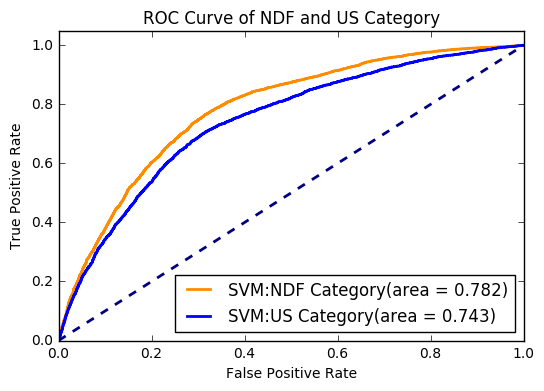

In [81]:
#ROC Curve
auc_1=auc(fpr,tpr)
auc_2=auc(fpr_1,tpr_1)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='SVM:NDF Category(area = %0.3f)' % auc_1)
plt.plot(fpr_1, tpr_1,
         lw=lw, label='SVM:US Category(area = %0.3f)' % auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of NDF and US Category')
plt.legend(loc="lower right")
plt.show()

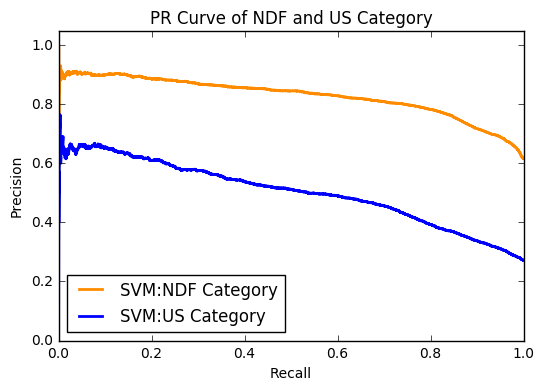

In [84]:
#PR Curve
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='SVM:NDF Category')
plt.plot(recall_1, precision_1,
         lw=lw, label='SVM:US Category')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve of NDF and US Category')
plt.legend(loc="lower left")
plt.show()